In [1]:
import astropy
import hpgeom as hp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.io import fits
import os
from astropy.table import Table, vstack
import skyproj
import pyproj
import healsparse as hsp
import healpy as hp
import ugali
from __future__ import division
import warnings
from matplotlib.path import Path
from ugali.analysis.isochrone import factory as isochrone_factory
from ugali.utils.shell import get_iso_dir
import hats
import lsdb
from matplotlib.colors import LogNorm
from astropy.table import QTable
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.polynomial import polynomial
from numpy.polynomial.polynomial import polyvander2d
import numpy.ma as ma
import glob
import astropy.io.fits as fitsio
from astropy import table
import matplotlib as mpl
from scipy.interpolate import interp1d

In [3]:
from functions import polyfit2d, mkpol, select_isochrone, fit_bkg, delve_movie_maker, select_cutout, select_stream_cutout, spherical_harmonic_background_fit, movie_maker, get_filter_splines, filter_data, table_maker

In [4]:
#Read in Delve Data
delve_path = "/epyc/data/delve/dr3/delve_dr3_stellar_skim/"
delve_object = lsdb.read_hats(delve_path, columns=["COADD_OBJECT_ID", "RA", "DEC", 'MAG_PSF_SFD_G', 'MAG_PSF_SFD_R'])
#Read in Des Data
#first file
fileone = 'strange_findings/des_dr2_x_gaia_08131.fits'
hdulone = fits.open(fileone)
hdulone.info()
hdulone[1].columns
data = hdulone[1].data
# get columns
des_ra = data['DES_RA']
des_dec = data['DES_DEC']
gmag = data['DES_WAVG_MAG_PSF_G_DERED']
rmag = data['DES_WAVG_MAG_PSF_R_DERED']
# make table with columns
des = Table([des_ra, des_dec, gmag, rmag],
              names=('RA', 'Dec', 'gmag', 'rmag'))
fits_directory = 'strange_findings'
fits_files = [f for f in os.listdir(fits_directory) if f.endswith('.fits')]
# Read all in
fits_data = []
for fits_file in fits_files:
    with fits.open(os.path.join(fits_directory, fits_file)) as hdul:
        fits_data.append(hdul)
        data = hdul[1].data
        des_ra = data['DES_RA']
        des_dec = data['DES_DEC']
        gmag = data['DES_WAVG_MAG_PSF_G_DERED']
        rmag = data['DES_WAVG_MAG_PSF_R_DERED']
        temp_table = Table([des_ra, des_dec, gmag, rmag], names=('RA', 'Dec', 'gmag', 'rmag'))
        des = vstack([des, temp_table])

Filename: strange_findings/des_dr2_x_gaia_08131.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    106   16386R x 49C   [D, D, K, I, E, E, E, E, E, E, E, E, E, E, E, E, K, 30A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E]   


In [33]:
np.searchsorted?

Signature:       np.searchsorted(a, v, side='left', sorter=None)
Call signature:  np.searchsorted(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function searchsorted at 0x7f3538076ca0>
File:            ~/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/_core/fromnumeric.py
Docstring:      
Find indices where elements should be inserted to maintain order.

Find the indices into a sorted array `a` such that, if the
corresponding elements in `v` were inserted before the indices, the
order of `a` would be preserved.

Assuming that `a` is sorted:

======  ============================
`side`  returned index `i` satisfies
======  ============================
left    ``a[i-1] < v <= a[i]``
right   ``a[i-1] <= v < a[i]``
======  ============================

Parameters
----------
a : 1-D array_like
    Input array. If `sorter` is None, then it must be sorted in
    ascending order, otherwise `sorter` must be an array of indices
    that sort it.
v : arra

In [8]:
def get_filter_splines(age, mu, z, abs_mag_min=2.9, app_mag_max = 23.5, color_min=0, color_max=1, dmu=0.5, C=[0.05, 0.1], E=2.):
    iso = isochrone_factory('Dotter2016', survey='DES', age=age, distance_modulus=mu, z=z)
    err = lambda x: 0.0010908679647672335 + np.exp((x - 27.091072029215375) / 1.0904624484538419)
    gsel = (iso.mag > abs_mag_min) & (iso.mag + mu < app_mag_max)
    color =iso.color[gsel]
    mag = iso.mag[gsel]
    # Spread in magnitude     
    mnear = mag + mu - dmu / 2.
    mfar = mag + mu + dmu / 2.
    color_far = np.clip(color + E * err(mfar) + C[1], color_min, color_max)
    color_near = np.clip(color - E * err(mnear) - C[0], color_min,color_max)
    spline_far = interp1d(mag + mu, color_far , bounds_error=False, fill_value=np.nan)
    spline_near = interp1d(mag + mu, color_near, bounds_error=False, fill_value=np.nan)
    return spline_near, spline_far

def filter_data(color, mag, age, mu, z):
    sp_near, sp_far = get_filter_splines(age=age, mu = mu, z=z)
    near_vals = sp_near(mag)
    far_vals =  sp_far(mag)
    sel = (color > near_vals) & (color < far_vals)
    return sel #Sel is the boolean array

# 5-5-25: Needed these here for this session because I hadn't imported interp1d in the functions file at the time

In [48]:
def table_maker(data, mu_start=15, mu_end=18, mu_step=0.5, age=11., z=0.0007, gmag_title='gmag', rmag_title='rmag', ra_title='RA', dec_title='Dec', nside=512):
    
    ra = data[ra_title]
    dec = data[dec_title]
    mu_arange = np.arange(mu_start, mu_end + mu_step, mu_step) # mu range
    
    pix = hp.ang2pix(512, ra, dec, lonlat=True) # all pixel ids in range
    upix = np.unique(pix, return_counts=False) # all unique pixel ids in range
    
    out_col_list = [(f'pix{nside}', 'int')] # this column will hold all the ids
    out_col_list += [f'{mu:.1f}'.replace('.','p') for mu in mu_arange] # now it's all the columns
    
    dtype_list = [(name, 'int') for name in out_col_list] # list of 'int' for each column
    hpx_array = np.recarray(shape=len(upix), dtype=dtype_list) # Make hpx array
    hpx_array.fill(0) # Make the default count value zero
    hpx_array[f'pix{nside}'] = upix # Set the hpx ids in the first column
    
    for mu in mu_arange:
        
        selector = filter_data(color=(data[gmag_title]-data[rmag_title]), mag=data[gmag_title], age=age, mu=mu, z=z) # Make matched-filter selection
        upix_sel, counts_sel = np.unique(pix[selector], return_counts=True) # Get the unique hpx ids and counts for the filter selection

        col_name = f'{mu:.1f}'.replace('.','p') # Get the column name
        hpx_array[col_name][np.searchsorted(upix, upix_sel)] = counts_sel # As far as I can tell, this works, but ask Peter
          
    return hpx_array

In [6]:
tiny_des_tester = des[(des['RA'] > 10) & (des['RA'] < 15) & (des['Dec'] > -25) & (des['Dec'] < -20) & (des['gmag'] < 23.5) & (des['gmag'] > 16) & (des['gmag'] - des['rmag'] < 1) & (des['gmag'] - des['rmag'] > 0)]

In [44]:
tab = table_maker(tiny_des_tester)

In [45]:
tab['pix512']

array([2108473, 2108474, 2108475, ..., 2237523, 2237524, 2237525],
      shape=(1864,))

In [47]:
tab['15p5']

array([2, 2, 0, ..., 0, 0, 0], shape=(1864,))

In [20]:
vertices = [(120, 5), (120, -40), (160, -40), (160, 5)]
delve_jet_box = delve_object.polygon_search(vertices)

In [47]:
delve_jet_box.compute()

,COADD_OBJECT_ID,RA,DEC,MAG_PSF_SFD_G,MAG_PSF_SFD_R
_healpix_29,,,,,
288230376689669892,7019576924,134.99871,0.001257,23.837413,23.339949
288230380352033181,7019576462,134.999191,0.008185,24.360325,24.23266
...,...,...,...,...,...
2882303755157386598,7019577883,134.992344,-0.010605,25.42448,24.595713
2882303757017862118,7019577484,134.994571,-0.006002,24.673328,24.663826


In [48]:
ra = delve_jet_box['RA'].compute().to_numpy()
dec = delve_jet_box['DEC'].compute().to_numpy()
g = delve_jet_box['MAG_PSF_SFD_G'].compute().to_numpy()
r = delve_jet_box['MAG_PSF_SFD_R'].compute().to_numpy()
delve_jet_table = Table([ra, dec, g, r], names=('RA', 'Dec', 'gmag', 'rmag'))

In [49]:
delve_jet_table

RA,Dec,gmag,rmag
float64,float64,float64,float64
134.99871,0.001257,23.837413350359743,23.33994862040568
134.999191,0.008185,24.36032456704677,24.23266044275175
135.008818,0.010038,24.62217478245903,24.288381172370823
134.992054,0.011162,24.056205923336954,23.126626061177266
134.997279,0.014281,22.33874107819436,20.942924096299
135.011704,0.014208,24.626464419044627,25.497867169248874
135.008938,0.013985,23.546645778192204,21.98966462783796
135.007798,0.013947,21.20932615799232,20.744719063622703
135.006429,0.014714,23.98162279040952,22.41413358700838


/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Latin Modern Roman'

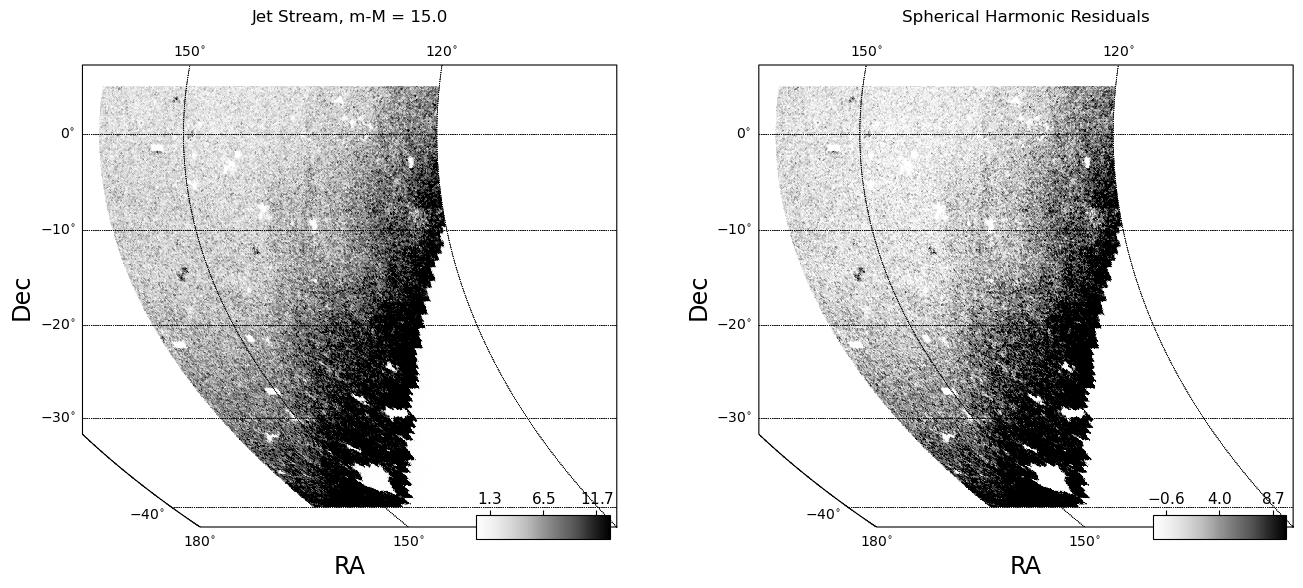

/astro/users/esb30/functions.py:476: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfon

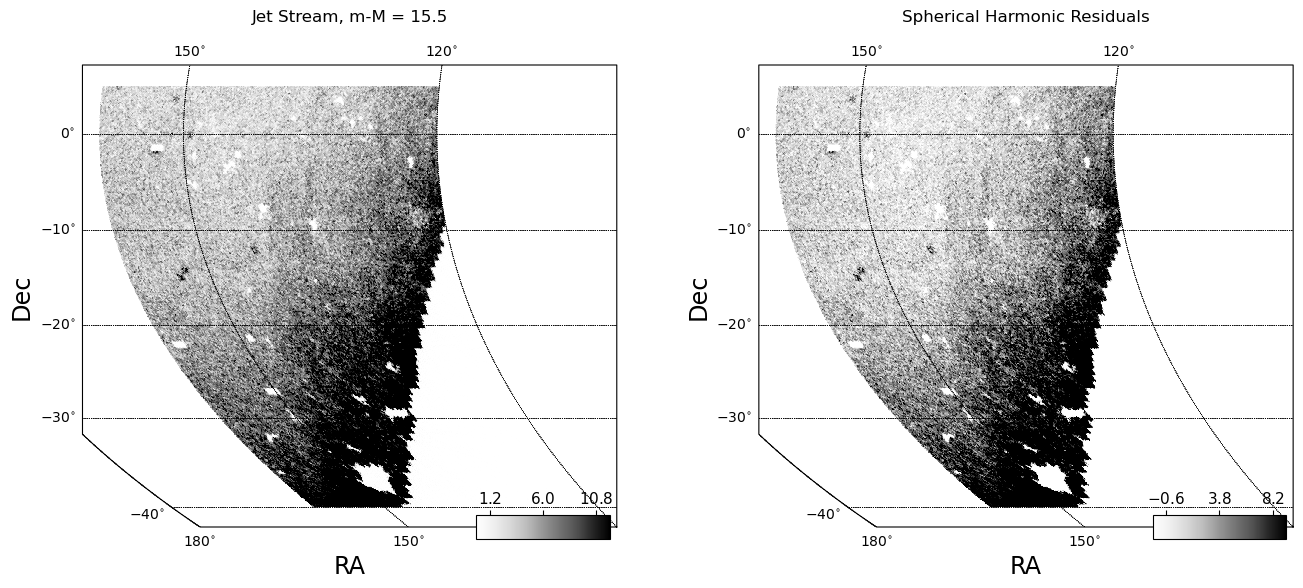

/astro/users/esb30/functions.py:476: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfon

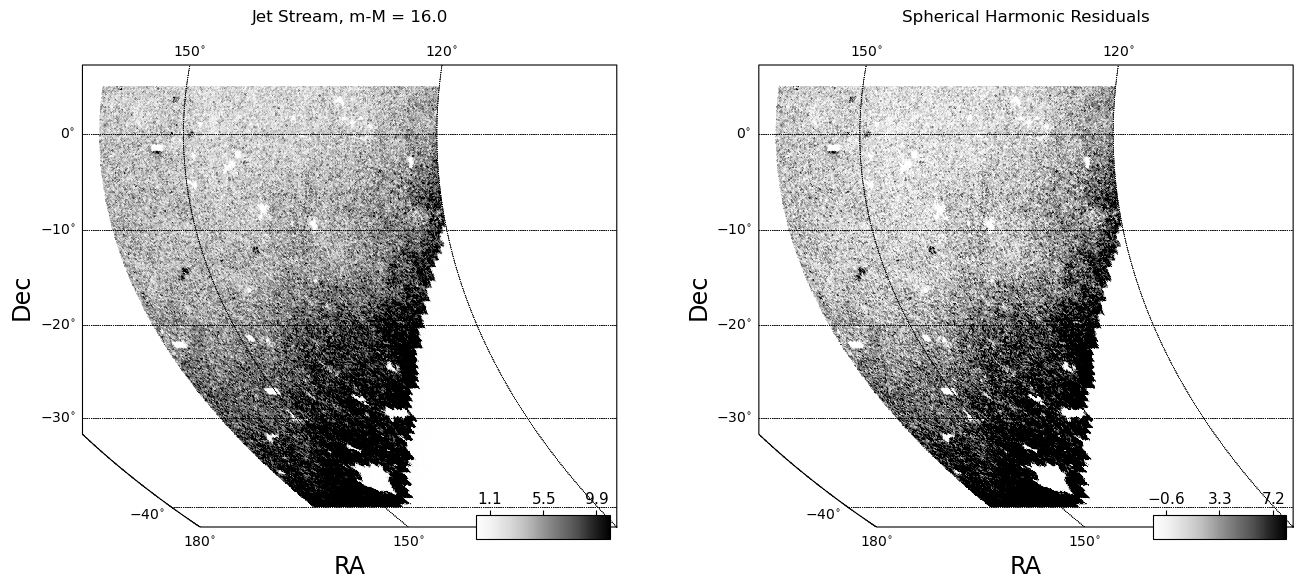

/astro/users/esb30/functions.py:476: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfon

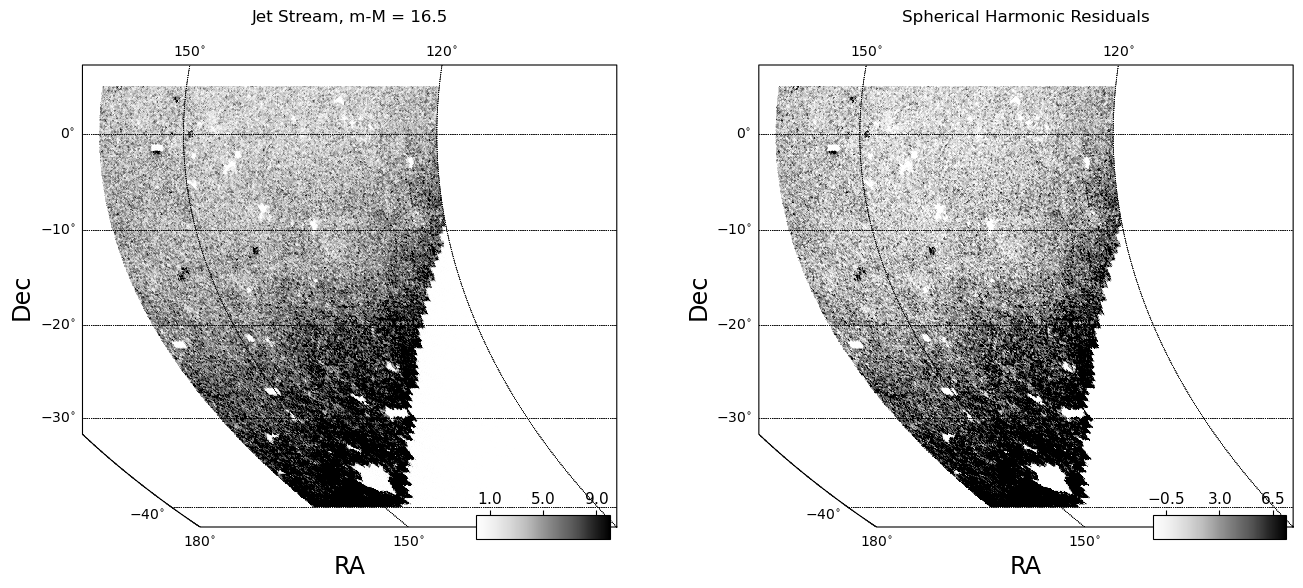

/astro/users/esb30/functions.py:476: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfon

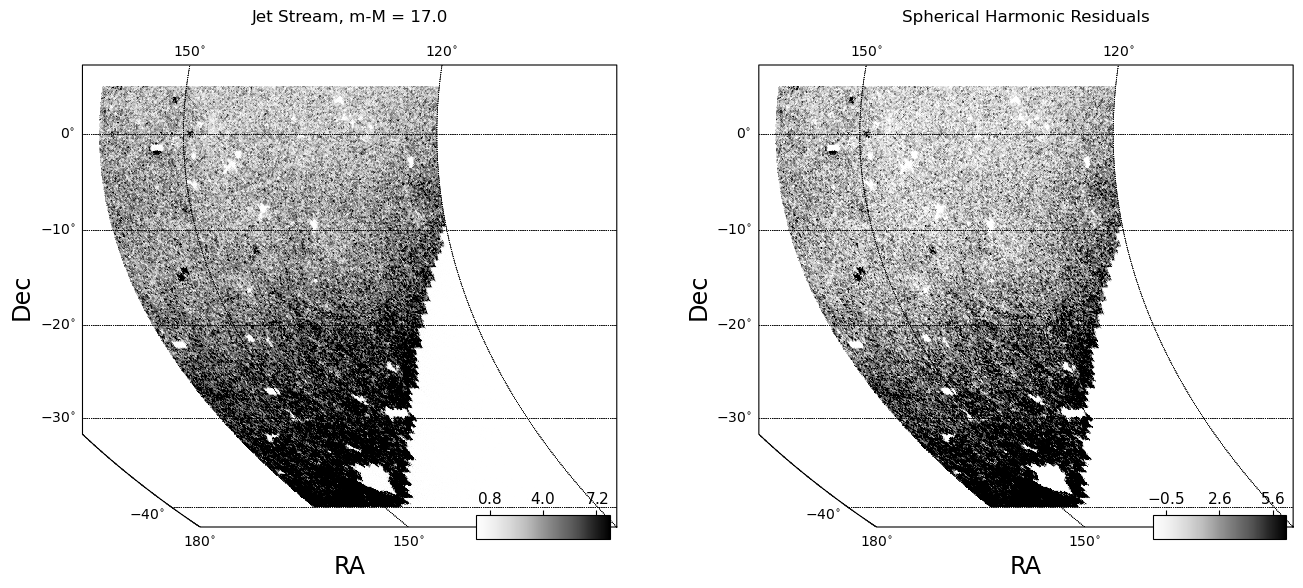

/astro/users/esb30/functions.py:476: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/astro/users/esb30/miniconda3/envs/streamz/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfont: Font family 'Latin Modern Roman' not found.
findfon

Error in callback <function flush_figures at 0x7f82702fea20> (for post_execute), with arguments args (),kwargs {}:


In [ ]:
for mu in np.arange(15, 18.5, 0.5):

        mu_col = np.array(jet_isochrone_table[f'Mu = {mu}'])
        min1, max1 = np.percentile(mu_col[~(mu_col == hp.UNSEEN)], [5,100])
        mask_sel = (mu_col < min1 -1) | (mu_col > max1)
        masked_array_here = np.ma.array(mu_col, mask=mask_sel, fill_value=hp.UNSEEN)

        harmonic_jet_residuals, harmonic_jet_bkg = spherical_harmonic_background_fit(masked_array_here, lmax=3)

        mpl.rcParams['font.family'] = 'Latin Modern Roman'

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        sp = skyproj.McBrydeSkyproj(ax=ax1)
        valid = masked_array_here[~(masked_array_here.mask | (masked_array_here == hp.UNSEEN))]
        vmin, vmax = np.percentile(valid, [5,99.5])
        smooth1 = hp.smoothing(masked_array_here.filled(0), np.radians(0.1))
        thing1 = sp.draw_hpxmap(smooth1, cmap='Greys', vmin=vmin, vmax=vmax, lon_range=[120, 160], lat_range=[-40, 5])
        sp.ax.set_title(f'Jet Stream, m-M = {mu:.1f}', y=1.05, pad=15)
        sp.ax.set_xlabel('RA')
        sp.ax.set_ylabel('Dec')
        sp.draw_inset_colorbar(loc=4)

        sp = skyproj.McBrydeSkyproj(ax=ax2)
        valid = harmonic_jet_residuals[~(harmonic_jet_residuals.mask | (harmonic_jet_residuals == hp.UNSEEN))]
        vmin, vmax = np.percentile(valid, [5,99.5])
        smooth2 = hp.smoothing(harmonic_jet_residuals.filled(0), np.radians(0.1))
        thing2 = sp.draw_hpxmap(smooth2, cmap='Greys', vmin=vmin, vmax=vmax, lon_range=[120, 160], lat_range=[-40, 5])
        sp.ax.set_title(f'Spherical Harmonic Residuals', y=1.05, pad=15)
        sp.ax.set_xlabel('RA')
        sp.ax.set_ylabel('Dec')
        sp.draw_inset_colorbar(loc=4)

        plt.savefig(f'{mu}_jet_slice.png', dpi=300, bbox_inches='tight')
        plt.show()